# Lab 4-6: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_6_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before November 21 at 23:59 and put **"AML-L4-6"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_sparse_spd_matrix
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
from copy import deepcopy
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [2]:
class my_GMM():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, initialization = 'random', tol = 10**-6, it_max = 100):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n, p = X.shape
        k = self.k
        if initialization == 'random' :
            self.mu_ = 1- 2 * np.random.rand(k, p)
            self.Sigma_ = np.zeros((k, p, p))
            for i in range(k) :
                self.Sigma_[i, :] = make_sparse_spd_matrix(p)
            self.alpha_ = np.random.rand(k)
            self.alpha_ = self.alpha_/np.sum(self.alpha_)
        
        self.cond_prob_ = np.zeros((n, k))

        it = 0
        convergence = False
        
        while not convergence :
            density = np.zeros((n, k))
            for i in range (k):
                try : density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
                except: 
                    self.Sigma_[i] += 1e-8*np.eye(self.Sigma_[i].shape[0]) 
                    density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
            cond_prob_ = self.alpha_.T * density
            self.log_likelihood = np.log(np.sum(cond_prob_,axis=1))
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_ 
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
                                 
            mu_ = (1/self.alpha_)[:, np.newaxis] * np.mean(np.expand_dims(X, axis = 1) * self.cond_prob_[:, :, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            
            tmp = np.expand_dims(X, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = (1/self.alpha_)[:, np.newaxis, np.newaxis] * np.mean(self.cond_prob_[:, :, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                              axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            it = it + 1
            err = delta_alpha + delta_cond_prob + delta_mu_ + delta_sigma
            if it > it_max or (err < tol) :
                convergence  = True
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)   

    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        cond_prob_ = self.compute_proba(X)
        
        return np.argmax(cond_prob_, axis = 1)
           
    def compute_likelihood(self, X):
        """ Compute the mean of the likelihood for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        the likelihood of X        
        """
        n, p = X.shape
        k = self.k   
        density = np.zeros((n, k))
        for i in range (k):
            try : density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
            except: 
                self.Sigma_[i] += 1e-8*np.eye(self.Sigma_[i].shape[0]) 
                density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
        cond_prob_ = self.alpha_.T * density
        self.log_likelihood = np.mean(np.log(np.sum(cond_prob_,axis=1)))
        return(self.log_likelihood)
    
    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        density = np.zeros((n, k))
        for i in range (k):
            density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])

        cond_prob_ = self.alpha_.T * density
        cond_prob_ = self.cond_prob_ / np.sum(self.cond_prob_, axis = 1)
        return cond_prob_

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

In [3]:
## Génération d'une mixture de k gaussiennes
k = 4
p = 2
np.random.seed(1)
list_of_x = []
labels = []
for i in range(k) :
    n_i = np.random.randint(100, 1000)
    mu_i = (i+1) * (1 - 2* np.random.rand(p))
    vec_cov_i = np.random.rand(p, p)
    cov_i = np.dot(vec_cov_i, vec_cov_i.T)
    x_i = np.random.multivariate_normal(mu_i, cov_i, n_i)
    list_of_x.append(x_i)
    labels.append(i * np.ones(n_i))
X = np.concatenate(list_of_x)
labels = np.concatenate(labels)
shuffle = np.arange(len(X))
np.random.shuffle(shuffle)
X = X[shuffle]
labels = labels[shuffle]  

Text(0.5, 1.0, 'k means predicted labels')

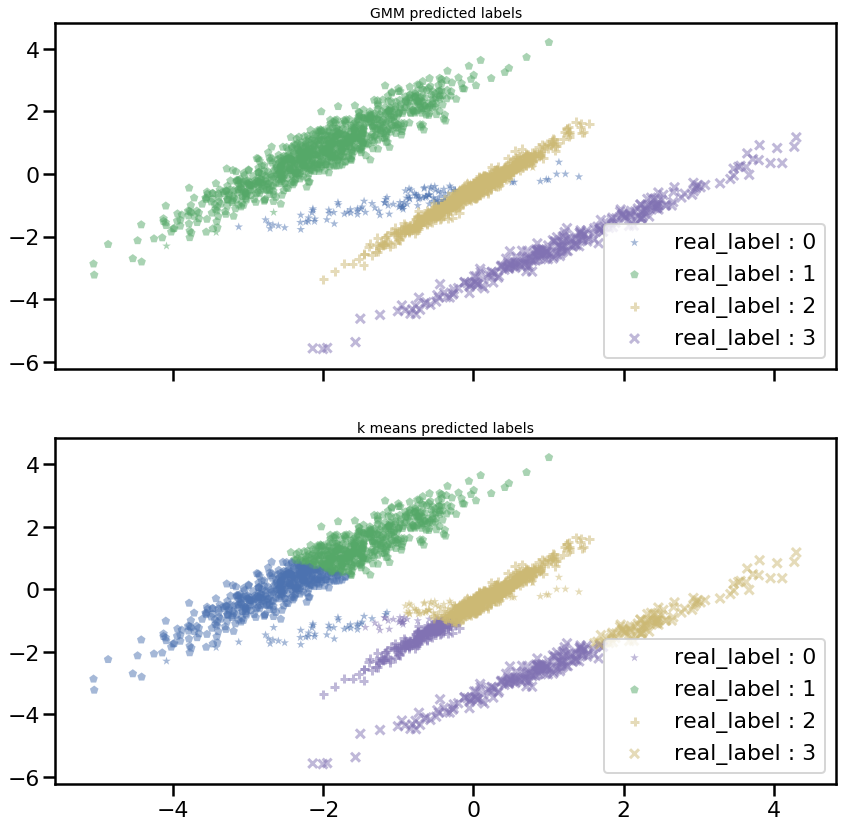

In [4]:
##Fitting et comparaison avec d'autres modèles
np.random.seed(0)
model = my_GMM(k)
model.fit(X, it_max = 1000, tol = 10**-10);

kmeans = KMeans(n_clusters=4, max_iter=200).fit(X)
fig, ax = plt.subplots(2,1, figsize =(14, 14), sharex = True, sharey = True)
marker_style = ['*','p','+', 'x']
color_map = ['b' , 'g', 'y', 'm']

for label_gt in range(k):
    labels_pred = model.labels_[np.where(labels==label_gt)]
    color_labels_pred = [color_map[i] for i in labels_pred]
    ax[0].scatter(X[:, 0].T[np.where(labels==label_gt)], X[:, 1].T[np.where(labels==label_gt)],
                  c=color_labels_pred, marker=marker_style[label_gt],
                   **plot_kwds, label= 'real_label : {}'.format(label_gt))
    labels_pred = kmeans.labels_[np.where(labels==label_gt)]
    color_labels_pred = [color_map[i] for i in labels_pred]
    ax[1].scatter(X[:, 0].T[np.where(labels==label_gt)], X[:, 1].T[np.where(labels==label_gt)],
                  c=color_labels_pred, marker=marker_style[label_gt],
                   **plot_kwds, label= 'real_label : {}'.format(label_gt))

ax[0].legend()
ax[1].legend()
ax[0].set_title('GMM predicted labels', size = 14);
ax[1].set_title('k means predicted labels', size = 14)

#### Bonus (not graded): Implement a mixture of asymmetric generalized Gaussians (AGGD)

### Second Part
 
- Implement the information criterions from the lecture (AIC, BIC, etc.) to select the number of clusters:

### Informations criterions 
#### AIC critetion

In [5]:
def compute_AIC(k, data): 
    model = my_GMM(k)
    model.fit(data, it_max = 5000, tol = 10**-10);
    number_parameters = k * (model.mu_.shape[1] + 1 + model.mu_.shape[1] * (model.mu_.shape[1] + 1) / 2 ) - 1
    return (np.sum(model.log_likelihood) -  number_parameters )

In [6]:
def compute_AIC_small_samples(k, data): 
    model = my_GMM(k)
    model.fit(data, it_max = 5000, tol = 10**-10);
    number_parameters = k * (model.mu_.shape[1] + 1 + model.mu_.shape[1] * (model.mu_.shape[1] + 1) / 2 ) - 1
    return (np.sum(model.log_likelihood) -  number_parameters - number_parameters*(number_parameters + 1) / (data.shape[0] - number_parameters -1))

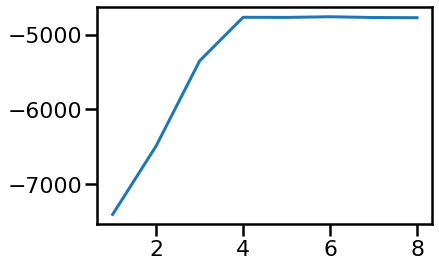

In [7]:
AICs = []
range_k = range(1,9)
np.random.seed(0)
for k in range_k: 
    AICs.append(compute_AIC(k,X))
plt.plot(range_k, AICs)

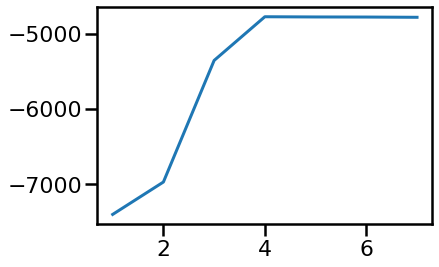

In [8]:
AICs = []
range_k = range(1,8)
np.random.seed(42)
for k in range_k: 
    AICs.append(compute_AIC_small_samples(k,X))
plt.plot(range_k, AICs)

#### BIC Criterion

In [9]:
def compute_BIC(k,data): 
    model = my_GMM(k)
    model.fit(data, it_max = 5000, tol = 10**-10);
    number_parameters = k * (model.mu_.shape[1] + 1 + model.mu_.shape[1] * (model.mu_.shape[1] + 1) / 2 ) - 1
    return (np.sum(model.log_likelihood) -   X.shape[0] * number_parameters/ 2)

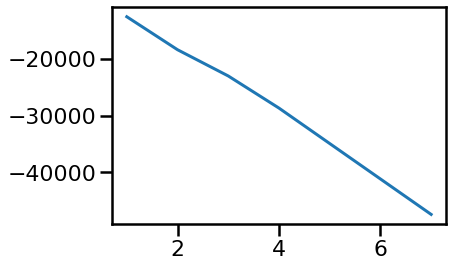

In [10]:
BICs = []
np.random.seed(42)
for k in range_k: 
    BICs.append(compute_BIC(k, X))
plt.plot(range_k, BICs)

## Merging Strategy

- Implement the merge criterions 
    - Correlation coefficients
    - Measuring Error 
    - Comparing the parameters

In [11]:
class my_GMM_merging():
    
    def __init__(self, k):
        '''
        Parameters:
        k: integer
            number of components
        
        Attributes:
        
        alpha_: np.array
            proportion of components
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.k = k
        self.alpha_ = None
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        
    def fit(self, X, initialization = 'random', tol = 10**-6, it_max = 100, merging='correlation', merging_value=0.95):
        """ Find the parameters
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        merging_value : either the correlation threshold, the likelyhood proportion accepted to be lost in a merge
                        
        Returns:
        -----
        self
        """
        n, p = X.shape
        
        if initialization == 'random' :
            self.mu_ = 1- 2 * np.random.rand(self.k, p)
            self.Sigma_ = np.zeros((self.k, p, p))
            for i in range(self.k) :
                self.Sigma_[i, :] = make_sparse_spd_matrix(p)
            self.alpha_ = np.random.rand(self.k)
            self.alpha_ = self.alpha_/np.sum(self.alpha_)
        
        self.cond_prob_ = np.zeros((n, self.k))
        
        it = 0
        convergence = False
        
        while not convergence :
            density = np.zeros((n, self.k))
            for i in range (self.k):
                try : 
                    density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
                except: 
                    self.Sigma_[i] += 1e-8*np.eye(self.Sigma_[i].shape[0]) 
                    density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
                

            
            
            if merging == 'error_based' : 
                ### In this case we merge before 
                density_unmerged = deepcopy(density)
                mu_unmerged = deepcopy(self.mu_)
                cond_prob_unmerged = deepcopy(self.cond_prob_)
                Sigma_unmerged = deepcopy(self.Sigma_)
                alpha_unmerged = deepcopy(self.alpha_)
                self.log_likelihood = np.sum(np.log(np.sum(self.alpha_.T * density_unmerged,axis=1)))
                log_likelihood_unmerged = self.log_likelihood
                ### Try to merge the two more correlated gaussian
                corr = np.corrcoef(self.cond_prob_.T)
                i,j = np.unravel_index(np.argmax(corr, axis=None), corr.shape)
                self.merge(i,j,X)
                density = np.zeros((n, self.k))
                for i in range (self.k):
                    try : 
                        density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
                    except: 
                        self.Sigma_[i] += 1e-8 * np.eye(self.Sigma_[i].shape[0]) 
                        density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])
                cond_prob_ = self.alpha_.T * density
                self.log_likelihood = np.sum(np.log(np.sum(cond_prob_,axis=1)))
                ratio = np.abs((self.log_likelihood - log_likelihood_unmerged) / log_likelihood_unmerged) 
                if ratio > merging_value: ### the likelihood has decreased too much
                    self.mu_ = mu_unmerged
                    self.cond_prob_ = cond_prob_unmerged
                    self.Sigma_ = Sigma_unmerged
                    self.alpha_ = alpha_unmerged
                    self.log_likelihood = log_likelihood_unmerged
                    density = density_unmerged
                    self.k += 1

                    
            cond_prob_ = self.alpha_.T * density     
            cond_prob_ = cond_prob_ / np.expand_dims(np.sum(cond_prob_, axis = 1), axis = 1)
            delta_cond_prob = np.max(np.abs(self.cond_prob_ - cond_prob_))
            self.cond_prob_ = cond_prob_ 
            
            alpha_ = np.mean(self.cond_prob_, axis = 0)
            delta_alpha = np.max(np.abs(self.alpha_ - alpha_))
            self.alpha_ = alpha_
                                 
            mu_ = (1/self.alpha_)[:, np.newaxis] * np.mean(np.expand_dims(X, axis = 1) * self.cond_prob_[:, :, np.newaxis], axis = 0)
            delta_mu_ = np.max(np.abs(self.mu_ - mu_))
            self.mu_ = mu_
            
            tmp = np.expand_dims(X, axis=1) - np.expand_dims(self.mu_, axis = 0)
            Sigma_ = (1/self.alpha_)[:, np.newaxis, np.newaxis] * np.mean(self.cond_prob_[:, :, np.newaxis, np.newaxis ] * np.matmul(np.expand_dims(tmp, -1), np.expand_dims(tmp, 2)),
                                              axis = 0)
            delta_sigma = np.max(np.abs(self.Sigma_ - Sigma_))
            self.Sigma_ = Sigma_
            it = it + 1
            err = delta_alpha + delta_cond_prob + delta_mu_ + delta_sigma
            if it > it_max or (err < tol) :
                convergence  = True
            
            
            if merging == 'correlation' : 
                corr = np.corrcoef(self.cond_prob_.T)
                np.fill_diagonal(corr,0)
                if np.max(corr) > merging_value :
                    i,j = np.unravel_index(np.argmax(corr, axis=None), corr.shape)
                    self.merge(i,j,X)
            elif merging == 'params_distance': 
                params = np.concatenate([self.Sigma_.reshape(self.Sigma_.shape[0],-1), 
                                         self.mu_.reshape(self.mu_.shape[0],-1),
                                         self.alpha_.reshape(self.alpha_.shape[0],-1)], axis=-1)
                params_dist = np.mean(np.abs(2 * (np.expand_dims(params,1)  - np.expand_dims(params,0) )/
                                             (np.abs((np.expand_dims(params,1)  + np.expand_dims(params,0) ))))
                                      ,axis=-1)
                np.fill_diagonal(params_dist, params_dist.max())
                i,j = np.unravel_index(np.argmin(params_dist, axis=None), params_dist.shape)
                if params_dist[i,j] < merging_value:
                    self.merge(i,j,X)
        self.labels_ = np.argmax(self.cond_prob_, axis = 1)   
    
    def merge(self, i, j,X): 
        """ Merge gaussian i and j
        
        """
        self.cond_prob_[:,i] = self.cond_prob_[:, i] + self.cond_prob_[:, j]
        self.alpha_[i] = self.alpha_[i] + self.alpha_[j]
        self.mu_[i] = (1/self.alpha_[i]) * np.mean(X * np.expand_dims(self.cond_prob_[:, i], -1), axis = 0)
        self.Sigma_[i] = (1/self.alpha_[i]) * np.mean(np.expand_dims(np.expand_dims(self.cond_prob_[:, i], -1),-1) * (np.expand_dims((X - self.mu_[i]),axis=-1) * np.expand_dims((X - self.mu_[i]),axis=1)),
                                              axis = 0)
        self.cond_prob_ = np.delete(self.cond_prob_, j, axis = -1)
        self.mu_ = np.delete(self.mu_, j, axis = 0)
        self.alpha_ = np.delete(self.alpha_, j, axis = 0)
        self.Sigma_ = np.delete(self.Sigma_, j, axis = 0)
        self.k -=1 
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        cond_prob_ = self.compute_proba(X)
        
        return np.argmax(cond_prob_, axis = 1)

    def compute_proba(self, X):
        """ Compute probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        n = X.shape[0]
        density = np.zeros((n, k))
        for i in range (k):
            density[:, i] = multivariate_normal.pdf(X, mean=self.mu_[i], cov=self.Sigma_[i])

        cond_prob_ = self.alpha_.T * density
        cond_prob_ = self.cond_prob_ / np.sum(self.cond_prob_, axis = 1)
        return cond_prob_

#### Correlation based merging

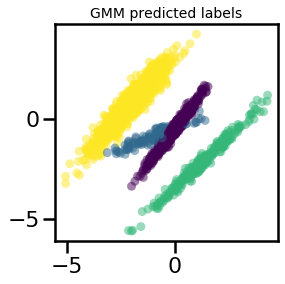

In [12]:
np.random.seed(0)
model = my_GMM_merging(5)
model.fit(X, it_max = 500, tol = 10**-10, merging_value=0.9)

fig, ax = plt.subplots(1,1, figsize =(4, 4), sharex = True, sharey = True)
ax.scatter(X[:, 0].T, X[:, 1].T,
              c=model.labels_,
               **plot_kwds)

ax.set_title('GMM predicted labels', size = 14);

We notice that the merging criterion works decently on the simple example, however the results are sensitive to the initialization and to the number of cluster used at the begining. 

#### Error based merging

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


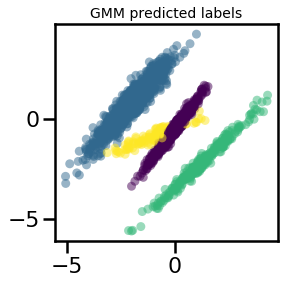

In [13]:
##Fitting et comparaison avec d'autres modèles
np.random.seed(0)
model = my_GMM_merging(9)
model.fit(X, it_max = 500, tol = 10**-10,merging = 'error_based', merging_value=0.05)

fig, ax = plt.subplots(1,1, figsize =(4, 4), sharex = True, sharey = True)
ax.scatter(X[:, 0].T, X[:, 1].T,
              c=model.labels_,
               **plot_kwds)

ax.set_title('GMM predicted labels', size = 14);

It seems that this creterion is less dependent on the number of clusters but that it is less stable concering the merging value. However the dataset is very simple and this observation has to be qualified.

#### Merging on based distance between parameters 

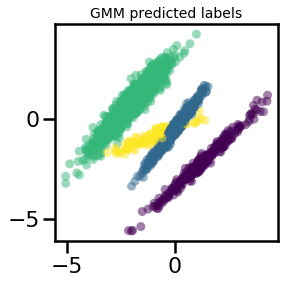

In [14]:
##Fitting et comparaison avec d'autres modèles
np.random.seed(0)
model = my_GMM_merging(7)
model.fit(X, it_max = 500, tol = 10**-10,merging = 'params_distance', merging_value=0.7)

fig, ax = plt.subplots(1,1, figsize =(4, 4), sharex = True, sharey = True)
ax.scatter(X[:, 0].T, X[:, 1].T,
              c=model.labels_,
               **plot_kwds)

ax.set_title('GMM predicted labels', size = 14);


### Cross Validation

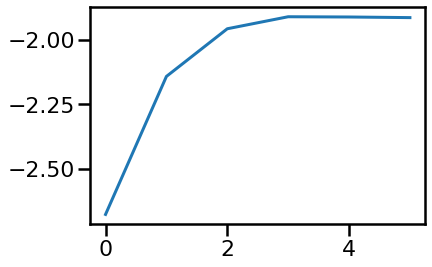

In [15]:
from sklearn.model_selection import KFold
range_k = range(2,8)
k_fold = 5
likelihoods = []
kf = KFold(n_splits=k_fold, shuffle=True, random_state=0)
for k in range_k: 
    splits = kf.split(X)
    mean_likelihood = 0
    for train_index, test_index in splits:
        model = my_GMM(k)
        model.fit(X[train_index], it_max = 500, tol = 10**-10)
        mean_likelihood += model.compute_likelihood(X[test_index])
    mean_likelihood /= len(range_k)
    likelihoods.append(mean_likelihood)
plt.plot(likelihoods)

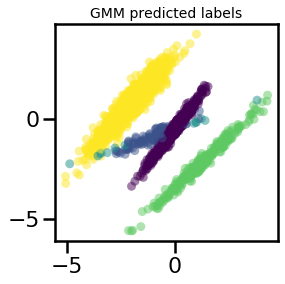

In [16]:
np.random.seed(0)
model = my_GMM(range_k[np.argmax(likelihoods)])
model.fit(X, it_max = 500, tol = 10**-10)

fig, ax = plt.subplots(1,1, figsize =(4, 4), sharex = True, sharey = True)
ax.scatter(X[:, 0].T, X[:, 1].T,
              c=model.labels_,
               **plot_kwds)

ax.set_title('GMM predicted labels', size = 14);

Use the model selection criterions to choose the number of clusters for the two given datasets (data-MM-i.csv). Compare the results and the computational time. Try to visually validate your results.

### Testing on the two dataset

In [17]:
import pandas as pd
dataset1 = np.asarray(pd.read_csv('data_MM_1-1.csv',header = None))
dataset2 = np.asarray(pd.read_csv('data_MM_2-1.csv',header = None))

#### AIC

 Computation for the first dataset for a range of 5 : 13.633216381072998 
 Computation for the second dataset for a range of 5 : 3.9931113719940186 


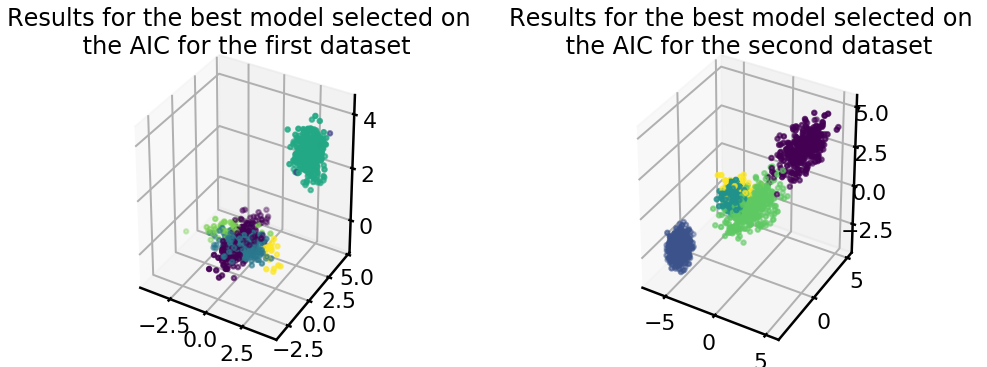

In [18]:
#### Compute the AIC for the first dataset
AICs = []
np.random.seed(42)
range_k = range(2,7)
start= time.time()
for k in range_k: 
    AICs.append(compute_AIC(k, dataset1))
model1 = my_GMM(range_k[np.argmax(AICs)])
model1.fit(dataset1, it_max = 5000, tol = 10**-10)
time_1 = time.time() - start
#### On the second dataset 
AICs = []
start= time.time()
for k in range_k: 
    AICs.append(compute_AIC(k, dataset2))
model2 = my_GMM(range_k[np.argmax(AICs)])
model2.fit(dataset2, it_max = 5000, tol = 10**-10)
time_2 = time.time() - start

### Visualize the results
fig = plt.figure(figsize =(14, 6))
fig.subplots_adjust(wspace=0.8)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Results for the best model selected on \n the AIC for the first dataset')
ax.scatter(dataset1[:, 0], dataset1[:, 1], dataset1[:, 2] , c=model1.labels_)

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Results for the best model selected on \n the AIC for the second dataset')
ax.scatter(dataset2[:, 0], dataset2[:, 1], dataset2[:, 2] , c=model2.labels_)

print(' Computation for the first dataset for a range of {} : {} '.format(len(range_k), time_1))
print(' Computation for the second dataset for a range of {} : {} '.format(len(range_k), time_2))

plt.show()

#### BIC 

 Computation for the first dataset for a range of 6 : 15.292181730270386 
 Computation for the second dataset for a range of 6 : 14.105295896530151 


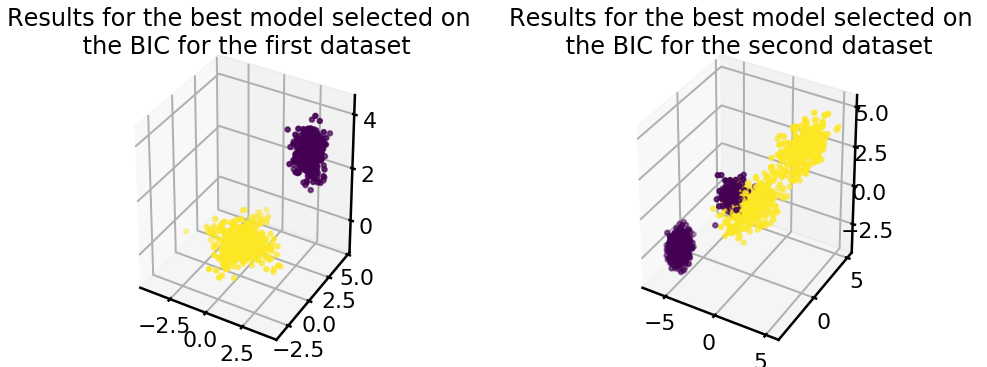

In [19]:
#### Compute the AIC for the first dataset
BICs = []
np.random.seed(42)
range_k = range(2,8)
start= time.time()
for k in range_k: 
    BICs.append(compute_BIC(k, dataset1))
model1 = my_GMM(range_k[np.argmax(BICs)])
model1.fit(dataset1, it_max = 5000, tol = 10**-10)
time_1 = time.time() - start
#### On the second dataset 
BICs = []
start= time.time()
for k in range_k: 
    BICs.append(compute_BIC(k, dataset2))
model2 = my_GMM(range_k[np.argmax(BICs)])
model2.fit(dataset2, it_max = 5000, tol = 10**-10)
time_2 = time.time() - start

### Visualize the results
fig = plt.figure(figsize =(14, 6))
fig.subplots_adjust(wspace=0.8)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Results for the best model selected on \n the BIC for the first dataset')
ax.scatter(dataset1[:, 0], dataset1[:, 1], dataset1[:, 2] , c=model1.labels_)

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Results for the best model selected on \n the BIC for the second dataset')
ax.scatter(dataset2[:, 0], dataset2[:, 1], dataset2[:, 2] , c=model2.labels_)

print(' Computation for the first dataset for a range of {} : {} '.format(len(range_k), time_1))
print(' Computation for the second dataset for a range of {} : {} '.format(len(range_k), time_2))

plt.show()

#### AIC for small dataset

 Computation for the first dataset for a range of 6 : 27.19560480117798 
 Computation for the second dataset for a range of 6 : 6.751970291137695 


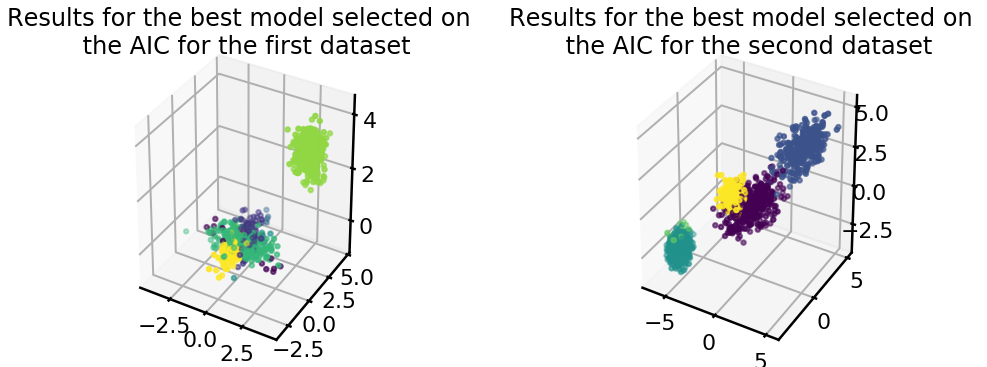

In [20]:
#### Compute the AIC for the first dataset
AICs = []
np.random.seed(42)
range_k = range(2,8)
start= time.time()
for k in range_k: 
    AICs.append(compute_AIC_small_samples(k, dataset1))
model1 = my_GMM(range_k[np.argmax(AICs)])
model1.fit(dataset1, it_max = 5000, tol = 10**-10)
time_1 = time.time() - start
#### On the second dataset 
AICs = []
start= time.time()
for k in range_k: 
    AICs.append(compute_AIC_small_samples(k, dataset2))
model2 = my_GMM(range_k[np.argmax(AICs)])
model2.fit(dataset2, it_max = 5000, tol = 10**-10)
time_2 = time.time() - start

### Visualize the results
fig = plt.figure(figsize =(14, 6))
fig.subplots_adjust(wspace=0.8)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Results for the best model selected on \n the AIC for the first dataset')
ax.scatter(dataset1[:, 0], dataset1[:, 1], dataset1[:, 2] , c=model1.labels_)

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Results for the best model selected on \n the AIC for the second dataset')
ax.scatter(dataset2[:, 0], dataset2[:, 1], dataset2[:, 2] , c=model2.labels_)

print(' Computation for the first dataset for a range of {} : {} '.format(len(range_k), time_1))
print(' Computation for the second dataset for a range of {} : {} '.format(len(range_k), time_2))

plt.show()

### MERGING 
#### Merging based on correlation

 Computation for the first dataset for a range of 6 : 0.1759781837463379 
 Computation for the second dataset for a range of 6 : 0.14657831192016602 


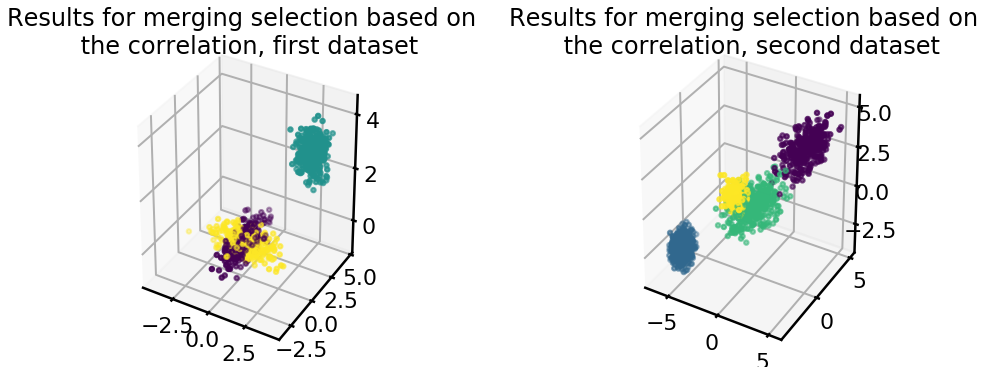

In [118]:
np.random.seed(42)
start= time.time()
model1 = my_GMM_merging(10)
model1.fit(dataset1, it_max = 5000, tol = 10**-10, merging_value=0)
time_1 = time.time() - start
### on the second dataset
start= time.time()
model2 = my_GMM_merging(10)
model2.fit(dataset2, it_max = 5000, tol = 10**-10, merging_value=0)
time_2 = time.time() - start

### Visualize the results
fig = plt.figure(figsize =(14, 6))
fig.subplots_adjust(wspace=0.8)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Results for merging selection based on \n the correlation, first dataset')
ax.scatter(dataset1[:, 0], dataset1[:, 1], dataset1[:, 2] , c=model1.labels_)

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Results for merging selection based on \n the correlation, second dataset')
ax.scatter(dataset2[:, 0], dataset2[:, 1], dataset2[:, 2] , c=model2.labels_)

print(' Computation for the first dataset for a range of {} : {} '.format(len(range_k), time_1))
print(' Computation for the second dataset for a range of {} : {} '.format(len(range_k), time_2))

plt.show()

 Computation for the first dataset for a range of 6 : 0.26958227157592773 
 Computation for the second dataset for a range of 6 : 0.25608372688293457 


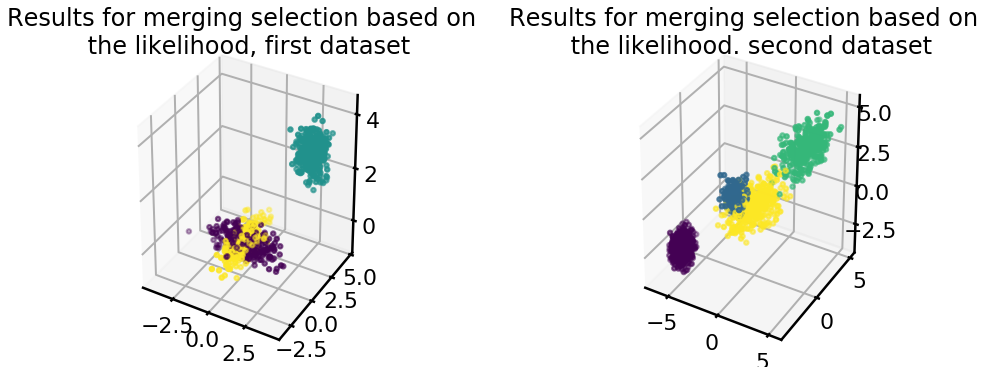

In [22]:
np.random.seed(42)
start= time.time()
model1 = my_GMM_merging(10)
model1.fit(dataset1, it_max = 5000, tol = 10**-10, merging = 'error_based',  merging_value=0.2)
time_1 = time.time() - start
### on the second dataset
start= time.time()
model2 = my_GMM_merging(10)
model2.fit(dataset2, it_max = 5000, tol = 10**-10, merging = 'error_based',  merging_value=0.2)
time_2 = time.time() - start

### Visualize the results
fig = plt.figure(figsize =(14, 6))
fig.subplots_adjust(wspace=0.8)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Results for merging selection based on \n the likelihood, first dataset')
ax.scatter(dataset1[:, 0], dataset1[:, 1], dataset1[:, 2] , c=model1.labels_)

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Results for merging selection based on \n the likelihood, second dataset')
ax.scatter(dataset2[:, 0], dataset2[:, 1], dataset2[:, 2] , c=model2.labels_)

print(' Computation for the first dataset for a range of {} : {} '.format(len(range_k), time_1))
print(' Computation for the second dataset for a range of {} : {} '.format(len(range_k), time_2))

plt.show()

 Computation for the first dataset for a range of 6 : 5.259335994720459 
 Computation for the second dataset for a range of 6 : 0.17569279670715332 


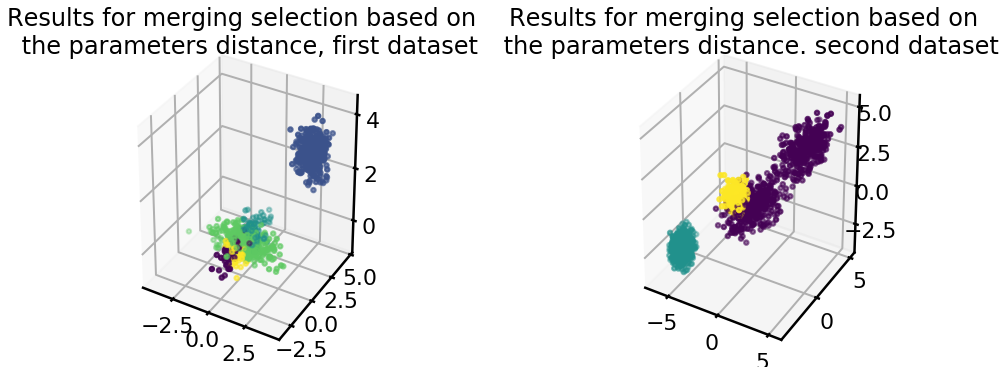

In [23]:
np.random.seed(42)
start= time.time()
model1 = my_GMM_merging(10)
model1.fit(dataset1, it_max = 5000, tol = 10**-10, merging = 'params_distance',  merging_value=0.9)
time_1 = time.time() - start
### on the second dataset
start= time.time()
model2 = my_GMM_merging(10)
model2.fit(dataset2, it_max = 5000, tol = 10**-10, merging = 'params_distance',  merging_value=0.9)
time_2 = time.time() - start

### Visualize the results
fig = plt.figure(figsize =(14, 6))
fig.subplots_adjust(wspace=0.8)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Results for merging selection based on \n the parameters distance, first dataset')
ax.scatter(dataset1[:, 0], dataset1[:, 1], dataset1[:, 2] , c=model1.labels_)

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Results for merging selection based on \n the parameters distance, second dataset')
ax.scatter(dataset2[:, 0], dataset2[:, 1], dataset2[:, 2] , c=model2.labels_)

print(' Computation for the first dataset for a range of {} : {} '.format(len(range_k), time_1))
print(' Computation for the second dataset for a range of {} : {} '.format(len(range_k), time_2))

plt.show()

### Cross-Validation

 Computation for the first dataset for a range of 6 : 17.64252543449402 
 Computation for the second dataset for a range of 6 : 15.93736481666565 


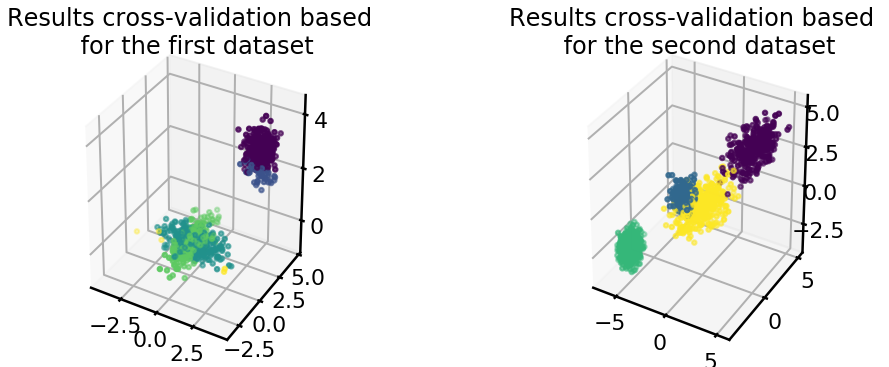

In [24]:
from sklearn.model_selection import KFold


start= time.time()
range_k = range(2,8)
k_fold = 5
likelihoods = []
kf = KFold(n_splits=k_fold, shuffle=True, random_state=0)
for k in range_k: 
    splits = kf.split(dataset1)
    mean_likelihood = 0
    for train_index, test_index in splits:
        model = my_GMM(k)
        model.fit(dataset1[train_index], it_max = 500, tol = 10**-10)
        mean_likelihood += model.compute_likelihood(dataset1[test_index])
    mean_likelihood /= len(range_k)
    likelihoods.append(mean_likelihood)
model1 = my_GMM(range_k[np.argmax(likelihoods)])
model1.fit(dataset1, it_max = 500, tol = 10**-10)    
time_1 = time.time() - start

### on the second dataset
start= time.time()
likelihoods = []
kf = KFold(n_splits=k_fold, shuffle=True, random_state=0)
for k in range_k: 
    splits = kf.split(dataset2)
    mean_likelihood = 0
    for train_index, test_index in splits:
        model = my_GMM(k)
        model.fit(dataset2[train_index], it_max = 500, tol = 10**-10)
        mean_likelihood += model.compute_likelihood(dataset2[test_index])
    mean_likelihood /= len(range_k)
    likelihoods.append(mean_likelihood)
model2 = my_GMM(range_k[np.argmax(likelihoods)])
model2.fit(dataset2, it_max = 500, tol = 10**-10)   
time_2 = time.time() - start

### Visualize the results
fig = plt.figure(figsize =(14, 6))
fig.subplots_adjust(wspace=0.8)
ax = fig.add_subplot(121, projection='3d')
ax.set_title('Results cross-validation based \n for the first dataset')
ax.scatter(dataset1[:, 0], dataset1[:, 1], dataset1[:, 2] , c=model1.labels_)

ax = fig.add_subplot(122, projection='3d')
ax.set_title('Results cross-validation based \n for the second dataset')
ax.scatter(dataset2[:, 0], dataset2[:, 1], dataset2[:, 2] , c=model2.labels_)

print(' Computation for the first dataset for a range of {} : {} '.format(len(range_k), time_1))
print(' Computation for the second dataset for a range of {} : {} '.format(len(range_k), time_2))

plt.show()

# Results
The merging strategy are faster than cross validation and Information based selection because it requires only one training. However this makes the results very dependent on the initialization and therefore unstable.
In terms of results the BIC and the AIC seems to be very dependent on the model / dataset used  : BIC is penalizing the complexity of the model too much (too few gaussian used) for our dataset and AIC is not penalizing enough (too many gaussian used). Cross-validation (in a long time interval) and merging methods (when carefully tuned) shows good results. Among the merging methods the correlation one seems to be the less variable wrt the merging value and will therefore be used for the application. 

## Application

You are going to work with the following data:

shape: (1797, 64)


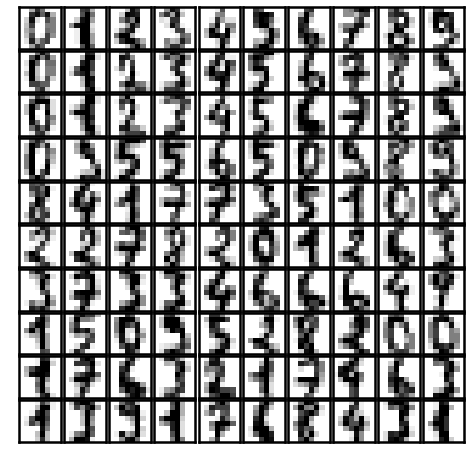

In [33]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method to produce new synthetic handwritten numbers. Explain why you used that model selection method in this case. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

## Approach 
We want to build new numbers from the Gaussian used to model the dataset. It seems to be reasonable to imagine that a good number of model should be 10. However, it appears that a 3 can be closed to a 8 or to 9 therefore we might want to have 11 clusters to be able to distinguish the 8 close from a 3 (because they are inclined or for other reason) from other type of 8. 
Because the training is very instablem we will use a merging criterion (good result in a short time with only one converging configuration required) with a fixed seed. 

In [114]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10, svd_solver='full')
X_digit = pca.fit_transform(digits.data)  
np.random.seed(6)
model = my_GMM_merging(12)
model.fit(X_digit, it_max = 1000, tol = 10**-6, merging_value=0);

In [115]:
generated = []
for i in range(model.k):
    for _ in range(9):
        number = pca.inverse_transform(np.random.multivariate_normal(mean=model.mu_[i], cov=model.Sigma_[i]))
        generated.append(number)
    number = pca.inverse_transform(model.mu_[i])
    generated.append(number)

number of cluster used  10


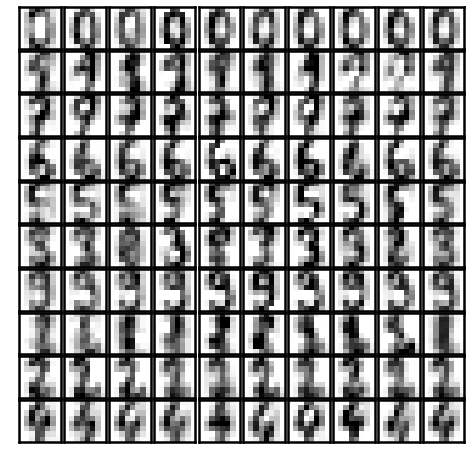

In [120]:
print('number of cluster used ',model.k) 
plot_digits(np.asarray(generated))

### Results
We plot some random samples from each of the gaussian and the mean of each gaussian. 
* Almost of the digit can be recognized from the mean (except 8)
* The variance from each cluster can be used to see which class are mixed  (the 8 is appearing with the 3 and the 8) 
* the number of cluster is 10